### Hands On Session: Dataset Engineering

### By Adi Nair, Anderson lab

In this section, we'll examine some common problems in datasets that hinders classification and other tasks and think of ways to fix them. We'll use the same dataset as before from [Remedios et al., 2017](https://https://www.nature.com/articles/nature23885) 

### Table of contents

#### 1) How well does your model perform by chance?
Creating null distributions & chance performance for linear models

#### 2) Class imbalances
Using resampling and shuffling to overcome class imbalances

#### 3) Data quality checks: Interpolation & Smoothing
Defining metrics to evaluate the quality of recordings & handle missing entries in datasets



In [35]:
import random

# Import neccessary modules and helper functions
# Need to delete unused packages

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.io import loadmat
from sklearn.decomposition import PCA
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import image
from sklearn.utils import shuffle
from scipy import interpolate
from imblearn.under_sampling import RandomUnderSampler

import imblearn


### Load data

Just as before let's load this dataset

In [36]:
remedios_data = loadmat("../../data/hypothalamus_calcium_imaging_remedios_et_al.mat");
robs = remedios_data['neural_data']
attack = remedios_data['attack_vector']
sex = remedios_data['sex_vector']

### 1) How well does your model perform by chance

We've previously seen that training a simple linear model to classify attack frames in this dataset fails due to the rarity of the attack label. But how bad did our models do?

We need to establish a baseline performance or chance-level performance as a lower bound for what we might expect our model to achieve. 

A simple way to do this is by shuffling our behavior vector independently of our neural activity matrix and using that shuffled vector for classification. This needs to be performed a finite number of times to estimate true chance performance.

#### Task: Shuffle attack_vector below and use that shuffled vector to perform simple linear classification below:

Train
[[0.94161641 0.        ]
 [0.05838359 0.        ]]
Test
[[0.93780607 0.        ]
 [0.06219393 0.        ]]


Text(0.5, 1.0, 'regression test performance for attack')

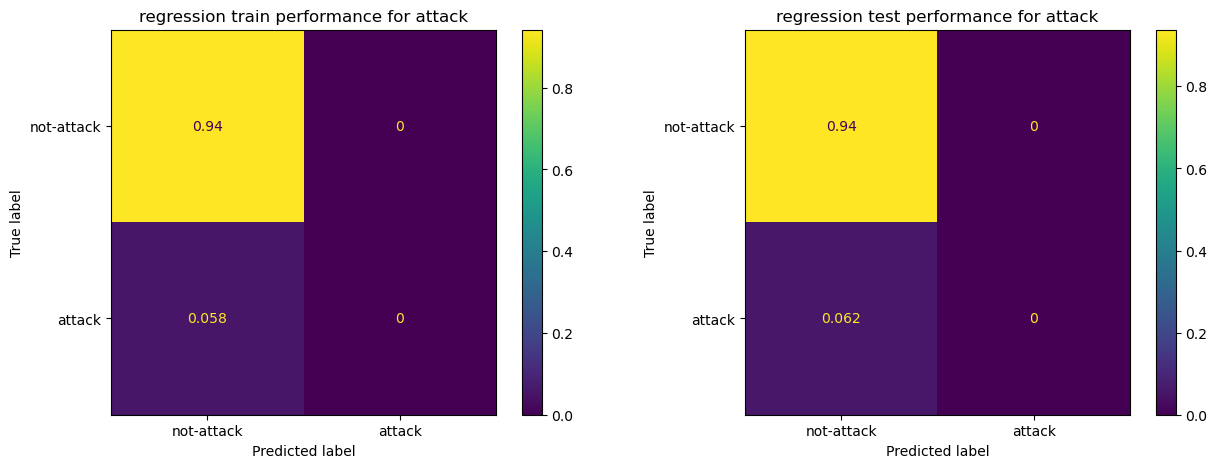

In [37]:
# Enter code here:
# shuffle attack vector
# vector needs to be transposed (values on different rows)
# for shuffle to work correctly
shuffled_attack = shuffle(attack.T)

# fit linear regression model to "predict" the shuffled attack behavior
# Enter code here:
import sklearn
X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(robs.T, shuffled_attack,
                                             test_size=0.33,
                                             shuffle=False,
                                             random_state=42)

reg = sklearn.linear_model.LinearRegression()
reg.fit(X_train, y_train)

pred_train = reg.predict(X_train)
pred_test = reg.predict(X_test)

thresh = 0.4

confmat_train = sklearn.metrics.confusion_matrix(y_train, pred_train > thresh, normalize = "pred")
#confmat_train = confmat_train / np.sum(confmat_train) # sums all by default
print("Train")
print(confmat_train)

confmat_test = sklearn.metrics.confusion_matrix(y_test, pred_test > thresh, normalize = "pred")
#confmat_test = confmat_test / np.sum(confmat_test) # sums all by default
print("Test")
print(confmat_test)

disp_train = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confmat_train,
    display_labels=["not-attack", "attack"])

disp_test = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confmat_test,
    display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')

#### Observe that even by chance, we can classify all 'not-attack' labels correctly 90% of the time! While that for attack by chance is around 0%.

If you ignored class-wise performance metrics, you can see why an average performance underestimates greatly the performance for classifying attack. 

There are also other important considerations for making a proper chance calculation for neural data that can be taken at the level of experimental design. [Harris 2022](https://www.biorxiv.org/content/10.1101/2020.11.29.402719v3#) is a great read on this topic and you'll encounter this tomorrow with Ann Kennedy

So, how can we account for the sparsity of the attack label?

### 2) Class imbalance

One method that allows us to fix this problem is to resample our dataset so that there are equal numbers of attack and non-attack labels. Resampling techniques are a broad class of tools that allow either random oversampling of the sparse label ('attack') or random undersampling of the majority label ('not-attack').

Python once again has an easy method to implement this in the form of the [imbalanced-learn](https://imbalanced-learn.org/stable/user_guide.html) library.

#### Task: Let's first perform random undersampling using [RandomUnderSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html) and then make a PCA plot using the resampled data below:

#### P.S You can also implement this manually! Try that out too below:

In [38]:
from collections import Counter
Counter(y_train[:,0])

Counter({0: 11709, 1: 726})

In [41]:
# Enter code here using imbalance-learn:
rus = RandomUnderSampler(random_state=42)

X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 726, 1: 726})


In [63]:
# Enter code for manual implementation here:
# sample k equal numbers of elements from each class (k=726)
attackidxs = np.where(attack[0,:] == 1)[0]
noattackidxs = np.where(attack[0,:] == 0)[0]

noattackidxs_subsampled = np.random.choice(noattackidxs, 726, replace=False)

In [65]:
balanced_indices = np.concatenate([attackidxs, noattackidxs_subsampled])
balanced_indices

array([7922, 7923, 7924, ..., 5869, 5500, 4664])

In [69]:
robs_subsample = robs[:,balanced_indices]
attack_subsample = attack[0,balanced_indices]
robs_subsample.shape, attack_subsample.shape

((115, 1833), (1833,))

Text(35, 5, 'attack')

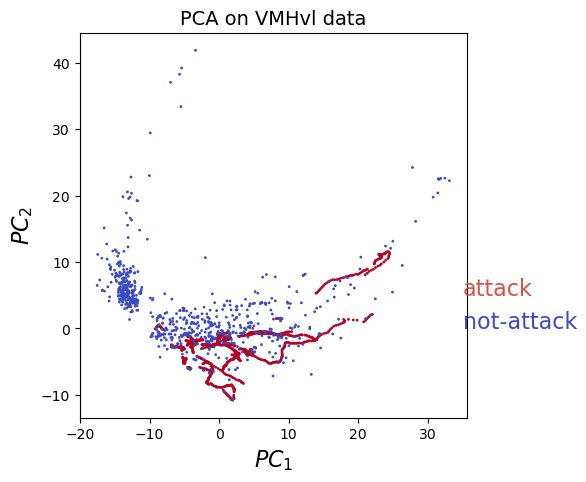

In [87]:
# perform PCA
pca_neural = PCA(n_components=2)
neural_pcs = pca_neural.fit_transform(robs_subsample.T)

# plot PCA, colored by intruder sex
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)
cmap = matplotlib.cm.get_cmap('coolwarm')

# neural_pcs.shape
ax.scatter(neural_pcs[:,0],neural_pcs[:,1], c = attack_subsample, s = 1,cmap=cmap)
ax.set_title('PCA on VMHvl data',fontsize = 14)
ax.set_xlabel('$PC_1$',fontsize=16)
ax.set_ylabel('$PC_2$',fontsize=16)
ax.text(35,0,'not-attack',color = cmap(0.0),fontsize=16)
ax.text(35,5,'attack',color = cmap(0.9),fontsize=16)

Great! As you can see, the resampled data contains an equal amount of attack and not-attack labels. 

#### Task: Train a simple linear model below to seperate data in the resampled case

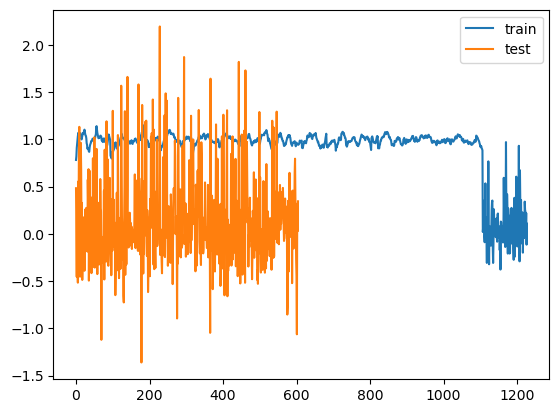

In [92]:
# Enter code here

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(robs.T, attack[0,:].T)

# fit linear regression model to "predict" the shuffled attack behavior
# Enter code here:
import sklearn
X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(robs_subsample.T,
                                             attack_subsample.T,
                                             test_size=0.33,
                                             shuffle=False,
                                             random_state=42)

reg = sklearn.linear_model.LinearRegression()
reg.fit(X_train, y_train)

pred_train = reg.predict(X_train)
pred_test = reg.predict(X_test)

plt.plot(pred_train, label='train')
plt.plot(pred_test, label='test')
plt.legend()
plt.show()

Train
[[1.         0.00717489]
 [0.         0.99282511]]
Test
[[1. 1.]
 [0. 0.]]


Text(0.5, 1.0, 'regression test performance for attack')

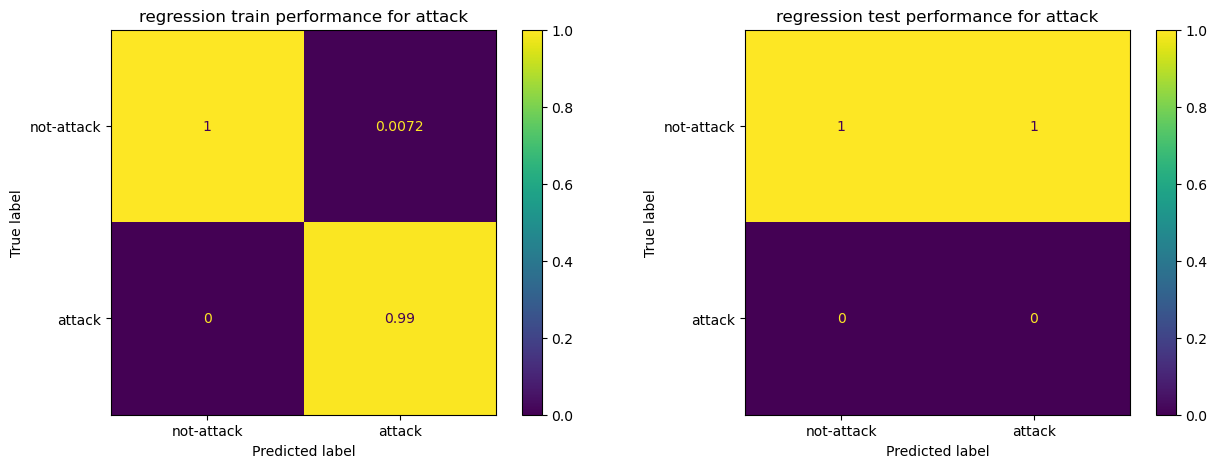

In [93]:
thresh = 0.4

confmat_train = sklearn.metrics.confusion_matrix(y_train, pred_train > thresh, normalize = "pred")
# use normalize="pred", don't normalize like the way below
#confmat_train = confmat_train / np.sum(confmat_train) # sums all by default
print("Train")
print(confmat_train)

confmat_test = sklearn.metrics.confusion_matrix(y_test, pred_test > thresh, normalize = "pred")
#confmat_test = confmat_test / np.sum(confmat_test) # sums all by default
print("Test")
print(confmat_test)

disp_train = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confmat_train,
    display_labels=["not-attack", "attack"])

disp_test = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confmat_test,
    display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')

#### Clearly, resampling helps and our model performance has greatly improved for the attack label! 

But what about the baseline or chance level performance of our model after resampling? 

Would the chance performance of the attack label still be zero? 

#### Task: Calculate a shuffled performance for the resampled case above 

Train
[[0.71186441 0.37040205]
 [0.28813559 0.62959795]]
Test
[[0.40223464 0.42018779]
 [0.59776536 0.57981221]]


Text(0.5, 1.0, 'regression test performance for attack')

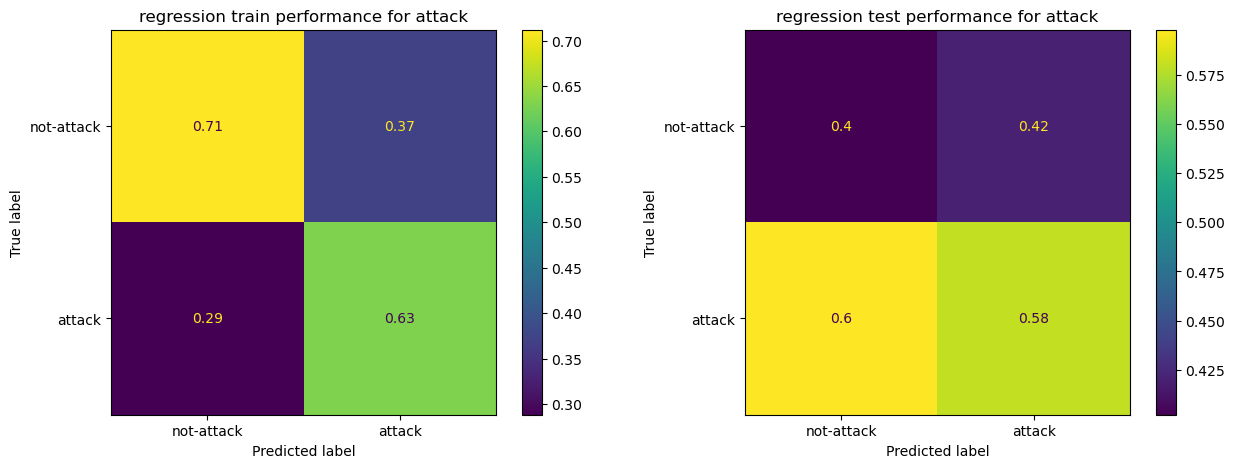

In [94]:
# Enter code here:
# Enter code here:
# shuffle attack vector
# vector needs to be transposed (values on different rows)
# for shuffle to work correctly
shuffled_attack = shuffle(attack_subsample.T)

# fit linear regression model to "predict" the shuffled attack behavior
# Enter code here:
import sklearn
X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(robs_subsample.T, shuffled_attack,
                                             test_size=0.33,
                                             shuffle=False,
                                             random_state=42)

reg = sklearn.linear_model.LinearRegression()
reg.fit(X_train, y_train)

pred_train = reg.predict(X_train)
pred_test = reg.predict(X_test)

thresh = 0.4

confmat_train = sklearn.metrics.confusion_matrix(y_train, pred_train > thresh, normalize = "pred")
#confmat_train = confmat_train / np.sum(confmat_train) # sums all by default
print("Train")
print(confmat_train)

confmat_test = sklearn.metrics.confusion_matrix(y_test, pred_test > thresh, normalize = "pred")
#confmat_test = confmat_test / np.sum(confmat_test) # sums all by default
print("Test")
print(confmat_test)

disp_train = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confmat_train,
    display_labels=["not-attack", "attack"])

disp_test = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confmat_test,
    display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')

#### Thus, about 50% of the time, out model would accurately classify attack. Since our model performance (>90%) is much greater than the chance performance, we can be confident that the linear model has learnt to distinguish attack from not-attack labels

### 2 b) Other resampling approaches

Besides random-undersampling, several other undersampling approaches can be easily implemented using imblearn, find out more about that [here](https://imbalanced-learn.org/stable/references/under_sampling.html)

Most deep learning packages such as PyTorch contain functions to perform resampling in their specified data structures but packages like imblearn are general purpose and are useful in many non deep learning scenarios

### 3) Data quality checks: 

When dealing with neural data, it's also important to assess data quality such as noise levels in your recording. Many data pre-processing pipelines (such as kilosort for electrophysiology data and CNMFe for calcium imaging data) already perform checks on data quality but in this exercise we'll think about how to identify corrupted or noisy data.


### Load corrupted dataset

In [96]:
remedios_data = loadmat("../../data/hypothalamus_corrupted_calcium_imaging_remedios_et_al.mat");
robs = remedios_data['neural_data_corrupted']
attack = remedios_data['attack_vector']
sex = remedios_data['sex_vector']


### 3 a) Interpolation of missing data

Plot the activity of neurons in neural_data below and examine it carefully. Some neurons have been corrupted to have missing entries (entries replaced by 0). Can you identify which neurons they are?

#### Hint: Think of ways which can be used to identify continous 'chunks' of zeros in the activity of individual neurons, hint hint: differentiate the signal and search for periods of time where the derivative is zero

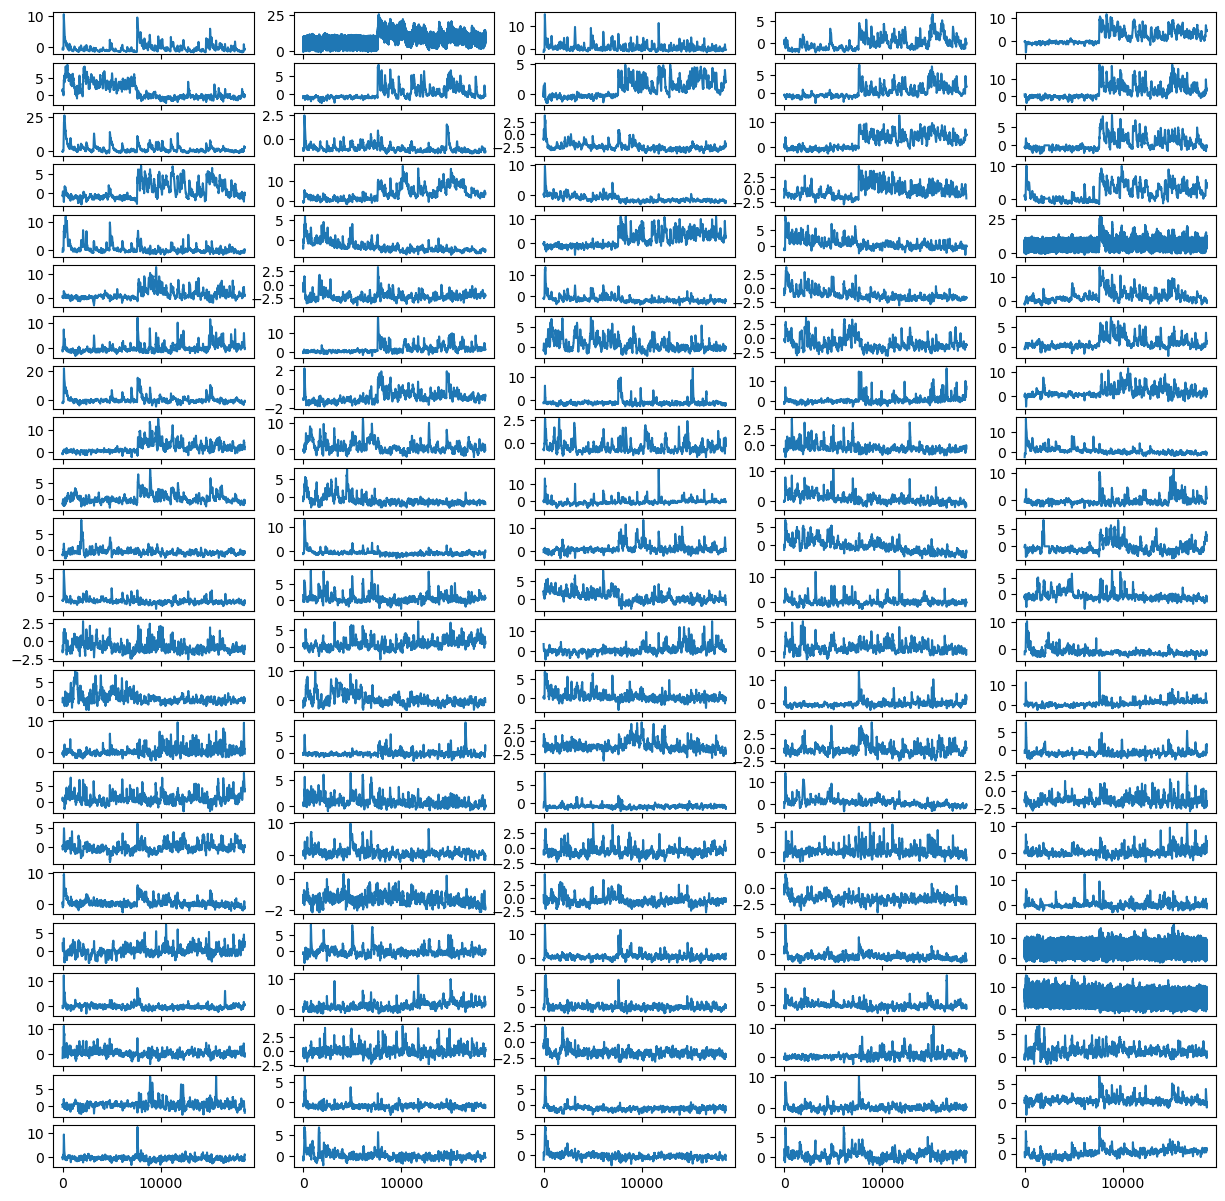

In [107]:
# Enter code here
fig = plt.figure(figsize=(15,15))
for i in range(robs.shape[0]):
    plt.subplot(23,5,i+1)
    plt.plot(robs[i,:])
plt.show()

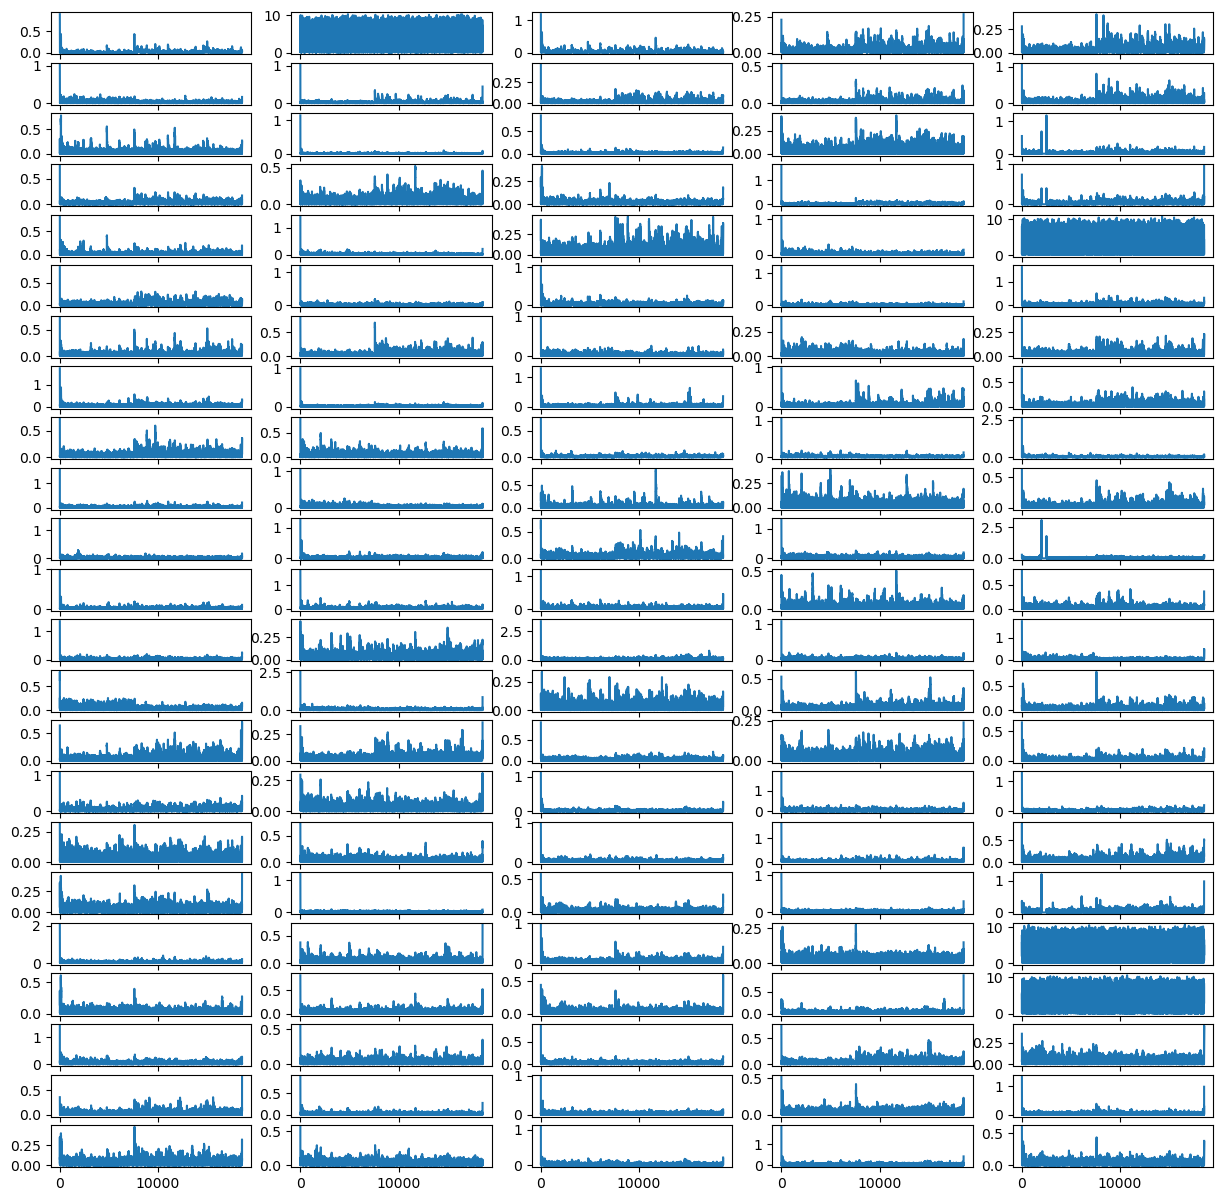

In [109]:
# Enter code here
fig = plt.figure(figsize=(15,15))
for i in range(robs.shape[0]):
    plt.subplot(23,5,i+1)
    shifted = np.zeros_like(robs[i,:])
    shifted[1:] = robs[i,:-1]
    plt.plot(np.abs(robs[i,:] - shifted))
plt.show()

## Identify neurons with missing values (runs of zeros)

In [155]:
# identify contiguous blocks of zeros, with a minimum length
def zero_runs(X, min_length):
    num_zero_runs = 0
    in_run = False
    for i in range(min_length, len(X)):
        if sum(X[i-min_length:i]) == 0:
            if not in_run:
                num_zero_runs = num_zero_runs + 1
                in_run = True # switch that we are now in a run
        else:
            in_run = False # we are out of a run
    return num_zero_runs

In [166]:
runs = zero_runs([0,0,0,1,0,0,1], min_length=3)

In [171]:
runs = []
for i in range(robs.shape[0]):
    num_zero_runs = zero_runs(robs[i,:], 5)
    if num_zero_runs > 0:
        runs.append((i, num_zero_runs))
print(runs)

[(14, 1), (19, 1), (54, 1), (89, 1)]


In [172]:
# Solution as a function
def zero_run_edges(X):
    # Create an array that is 1 where X is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(X, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

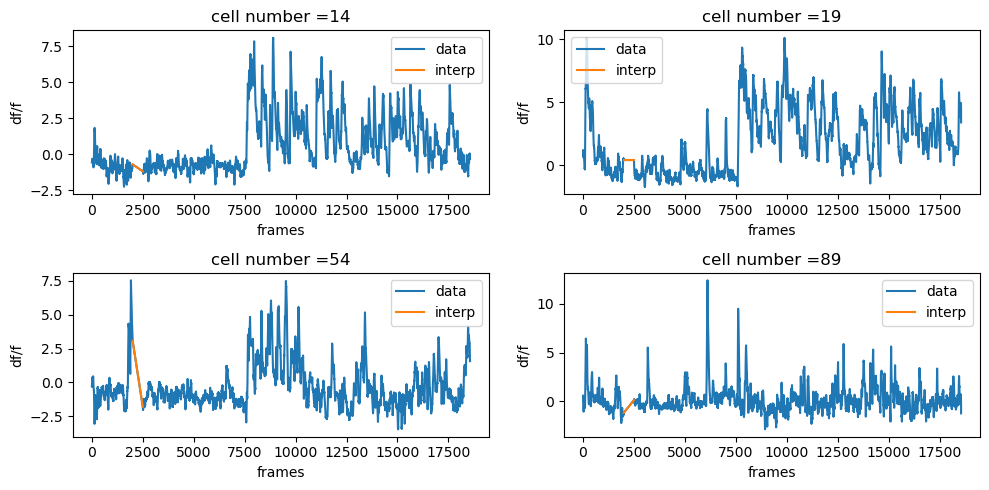

In [174]:
# Solution:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
for run, ax in zip(runs, axs.ravel()):
    idx, size = run
    idx_missing = zero_run_edges(robs[idx,:])
    y_range_neural = np.arange(0,len(robs[idx,:]),1, dtype=int)

    y_range_neural_inter = np.delete(y_range_neural, np.arange(idx_missing[0,0], idx_missing[0,1], 1))
    neural_inter = np.delete(robs[idx,:], np.arange(idx_missing[0,0], idx_missing[0,1], 1), axis = 0)

    f = interpolate.interp1d(y_range_neural_inter,neural_inter)
    ynew = np.arange(idx_missing[0,0], idx_missing[0,1], 1)
    xnew = f(ynew)

    ax.plot(y_range_neural_inter, neural_inter, '-', ynew, xnew, '-')
    ax.legend(['data','interp'])
    ax.set_xlabel('frames')
    ax.set_ylabel('df/f')
    ax.set_title('cell number =%i' %idx)
fig.tight_layout()

#### Great! Now how do we deal with such missing values?

One simple method involves [linear interpolation](https://www.cuemath.com/linear-interpolation-formula/) which can be implemented using scipy's [interp1d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)

#### Implement interp1d to fill in missing values of neurons identified above:

In [142]:
# Enter code here:
import scipy
print(attack.shape, robs.shape)
scipy.interpolate.interp1d(robs[], robs)

(1, 18561) (115, 18561)


### 3 b) Smoothing:

In addition to missing entries, neural signals may be corrupted by noise emanating from various sources, some biological and some technical. We've intentionally corrupted some neural signals in this dataset with added gaussian noise, can you identify them?

#### Plot the 4 corrupted neurons below: Hint: calculate the [signal-to-noise](https://github.com/scipy/scipy/blob/v0.16.0/scipy/stats/stats.py#L1963) ratio of each neurons and look at the top 4 neurons with highest SNR. 

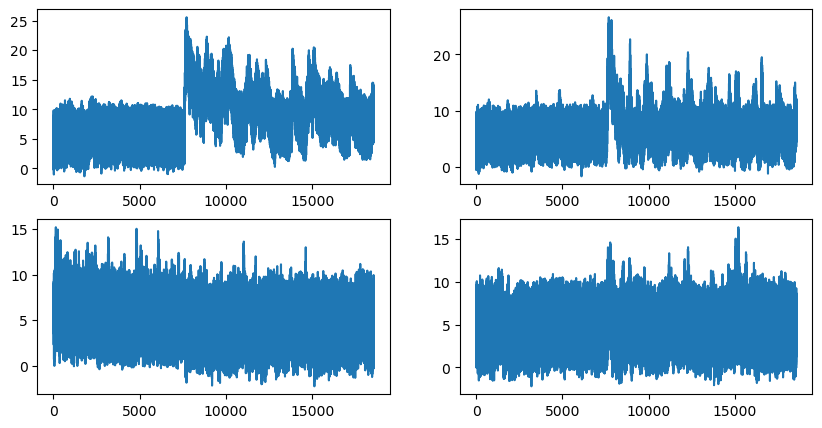

In [133]:
# Enter code here:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

snrs = []
for c in range(robs.shape[0]):
    snrs.append((c, signaltonoise(robs[c,:])))

snrs_sorted = sorted(snrs, key=lambda snr: snr[1])
snrs_sorted.reverse()

plt.figure(figsize=(10,5))
i = 1
for c, snr in snrs_sorted[0:4]:
    plt.subplot(2,2,i)
    plt.plot(robs[c,:])
    i = i + 1
plt.show()

### Moving average filter

 A simple method to smooth data is to average data in time bins, this can be written as:
 $y(i)  = 1/M \sum_{j = 0}^{M-1} x(i+j)$

#### Task: Implement moving average as a function below:

In [175]:
# Enter code here:
def smoothMA(a, WSZ):
    # a: NumPy 1-D or 2-D array containing the data to be smoothed (row-wise)
    # WSZ: smoothing window size needs, which must be odd number
    aSm = np.convolve(a, np.ones(WSZ)/WSZ, mode='full')
    return aSm

How well does a moving average filter perform at smoothing data? 

#### Task: Use the moving average filter you defined to smooth neural activity for identified neurons in 3 b)

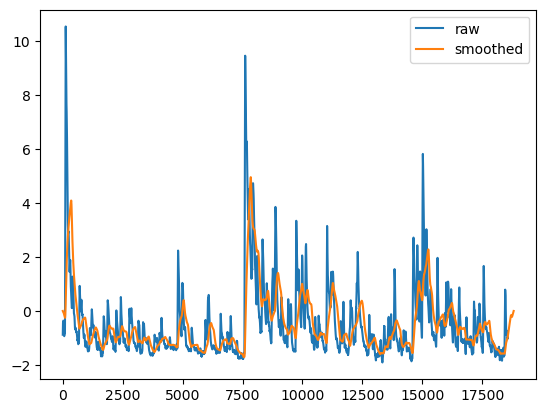

In [184]:
# Enter code here:
plt.plot(robs[0,:], label='raw')
plt.plot(smoothMA(robs[0,:], WSZ=255), label='smoothed')
plt.legend()
plt.show()

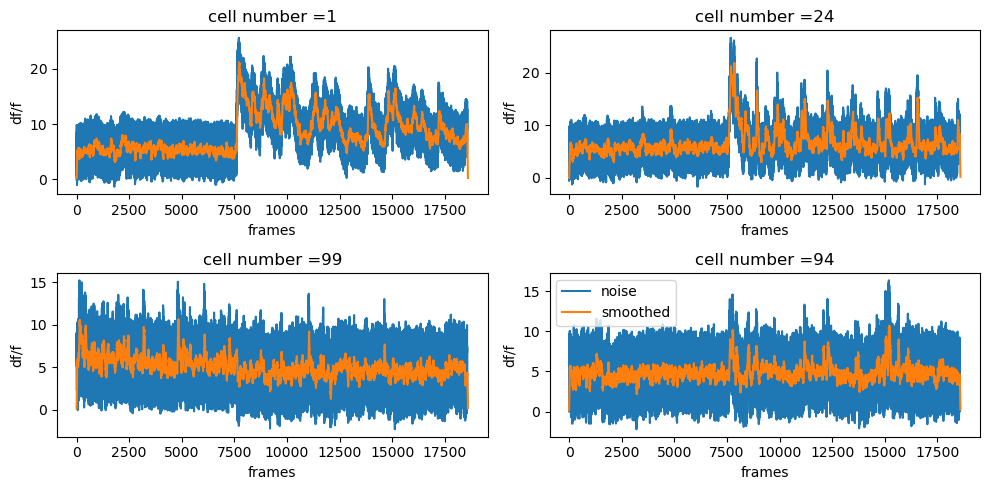

In [185]:
# Solution: 

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
for idx, ax in zip(snrs_sorted[0:4], axs.ravel()):
    c,snr = idx
    # filter df for ticker and plot on specified axes
    ax.plot(robs[c,:])
    ax.plot(smoothMA(robs[c,:],35))
    ax.set_xlabel('frames')
    ax.set_ylabel('df/f')
    ax.set_title('cell number =%i' %c)
    plt.legend(['noise','smoothed'])
fig.tight_layout()